### How does a movie's genre impact its box office revenue? 

This question aims to understand if certain genres are associated with higher revenues and if the relationship between genre and revenue changes over time.

In [186]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [187]:
df_movies = pd.read_csv('../data/movies_combined.csv')

#### 0. Descriptive statistics

How many different genres are there in our dataset? How many movies are there per genre? 

In [188]:
# convert string to list of genres
df_movies["movie_genres"] = df_movies["movie_genres"].apply(
    lambda x: [t[1] for t in eval(x)]
)

In [189]:
# get all unique genres across all movies
all_genres = set()
for genres in df_movies["movie_genres"]:
    all_genres.update(genres)

print(f"Number of unique genres: {len(all_genres)}")
print("Unique genres:")
print(sorted(all_genres))

Number of unique genres: 317
Unique genres:
['Absurdism', 'Acid western', 'Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure', 'Adventure Comedy', 'Airplanes and airports', 'Albino bias', 'Alien Film', 'Alien invasion', 'Americana', 'Animal Picture', 'Animals', 'Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Anthology', 'Anthropology', 'Anti-war', 'Anti-war film', 'Apocalyptic and post-apocalyptic fiction', 'Archaeology', 'Archives and records', 'Art film', 'Auto racing', 'Avant-garde', 'B-Western', 'B-movie', 'Backstage Musical', 'Baseball', 'Beach Film', 'Bengali Cinema', 'Biker Film', 'Biographical film', 'Biography', 'Biopic [feature]', 'Black comedy', 'Black-and-white', 'Blaxploitation', 'Bloopers & Candid Camera', 'Bollywood', 'Boxing', 'Breakdance', 'British Empire Film', 'British New Wave', 'Buddy cop', 'Buddy film', 'Business', 'Camp', 'Caper story', 'Cavalry Film', 'Chase Movie', 'Childhood Drama', "Childre

In [190]:
# count number of movies per genre
genre_counts = {}
for genres in df_movies["movie_genres"]:
    for genre in genres:
        if genre not in genre_counts:
            genre_counts[genre] = 0
        genre_counts[genre] += 1

# convert to dataframe and sort by count
genre_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['count'])
genre_df = genre_df.sort_values('count', ascending=False)

print("Number of movies per genre:")
print(genre_df)

Number of movies per genre:
                                 count
Drama                             5042
Comedy                            3522
Romance Film                      2311
Thriller                          2275
Action                            2037
...                                ...
Latino                               1
Fictional film                       1
Language & Literature                1
Family & Personal Relationships      1
Goat gland                           1

[317 rows x 1 columns]


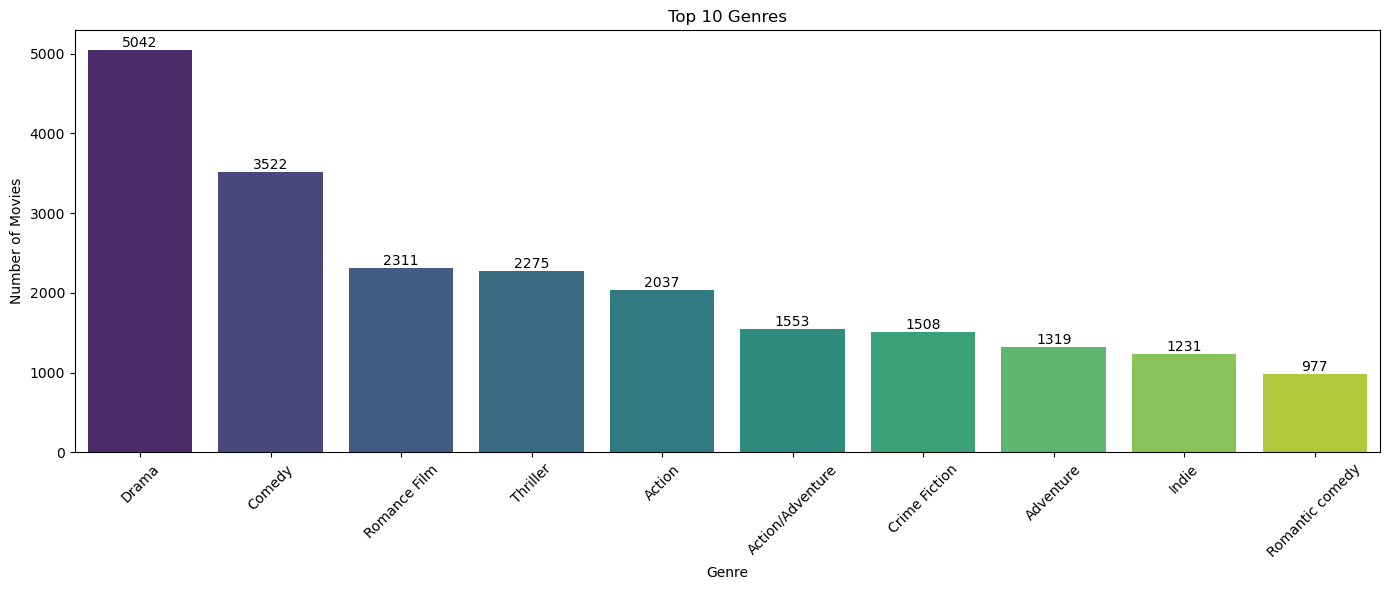

In [191]:
# plot top 10 genres as a bar plot
top_10_genres = genre_df.head(10)
plt.figure(figsize=(14, 6))
ax = sns.barplot(x=top_10_genres.index, y=top_10_genres['count'], hue=top_10_genres.index, palette="viridis")
# add the number of movies above each bar
for i, v in enumerate(top_10_genres['count']):
    ax.text(i, v, str(int(v)), ha='center', va='bottom')
plt.xticks(rotation=45)
plt.title("Top 10 Genres")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

In [192]:
# we will focus on the top 10 genres for the rest of the analysis
top_10_genres_list = genre_df.head(10).index.tolist()
print("Top 10 genres:")
print(top_10_genres_list)

# create a new dataframe with exploded genres, revenues and release years
df_genre_revenue = df_movies.explode('movie_genres')[['movie_genres', 'combined_revenue', 'release_year']]
# filter for only top-10 genres
df_genre_revenue = df_genre_revenue[df_genre_revenue['movie_genres'].isin(top_10_genres_list)]
print("\nNumber of rows in the new exploded dataframe:", len(df_genre_revenue))

Top 10 genres:
['Drama', 'Comedy', 'Romance Film', 'Thriller', 'Action', 'Action/Adventure', 'Crime Fiction', 'Adventure', 'Indie', 'Romantic comedy']

Number of rows in the new exploded dataframe: 21775


<div class="alert alert-success">

  💭 <strong>Idea:</strong>

  - Analyze the number of genres per movie, e.g. how many movies have 3 or more genres? 
  - Should we also analyze the genre combinations, e.g. Drama + Romance?
  
</div>

#### 1. What are the average and median revenues for each genre?

This question aims to identify which genres tend to perform better financially and detect any clear outliers.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>
  - Desctiptive statistics: mean, median, standard error of the mean
  - Visualization: bar plot
</div>

We will first compute the mean, median and standard error of the box office revenues for each of the top-10 genres.


In [193]:
# calculate average, median and standard error of the revenue per genre
genre_revenue_stats = df_genre_revenue.groupby('movie_genres').agg({
    'combined_revenue': ['mean', 'median', 'sem']
}).round(2)

# sort by mean revenue
genre_revenue_stats = genre_revenue_stats.sort_values(('combined_revenue', 'mean'), ascending=False)

print("Revenue statistics by genre (in dollars):")
print(genre_revenue_stats)

Revenue statistics by genre (in dollars):
                 combined_revenue                        
                             mean      median         sem
movie_genres                                             
Adventure            1.129471e+08  27107960.0  5872667.96
Action               8.331981e+07  20440627.0  3684960.16
Action/Adventure     7.208148e+07  18133495.0  3477093.01
Thriller             6.421261e+07  18564467.0  2735453.54
Comedy               4.727987e+07  13202485.0  1640832.40
Crime Fiction        4.496966e+07  12231010.0  2267670.32
Romance Film         3.928235e+07   9455232.0  1837037.15
Romantic comedy      3.899764e+07  13290368.0  2205923.00
Drama                3.627546e+07   7273916.5  1261306.70
Indie                1.226758e+07   2147715.0  1015297.16


For better interpretation, we will also use a bar plot to vizualize the means and standard error for each genre.

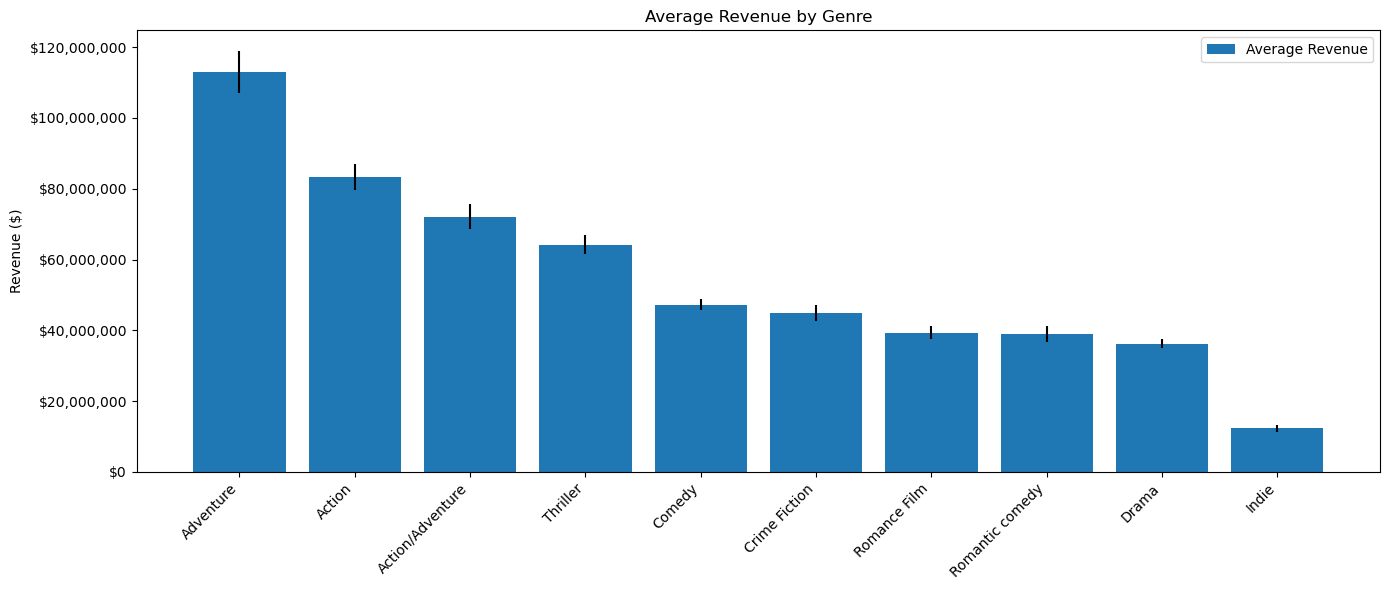

In [194]:
x = np.arange(len(genre_revenue_stats.index))
fig, ax = plt.subplots(figsize=(14, 6))
rects = ax.bar(x, genre_revenue_stats['combined_revenue', 'mean'], label='Average Revenue', yerr=genre_revenue_stats['combined_revenue', 'sem'])
ax.set_ylabel('Revenue ($)')
ax.set_title('Average Revenue by Genre')
ax.set_xticks(x)
ax.set_xticklabels(genre_revenue_stats.index, rotation=45, ha='right')
ax.legend()
# format y-axis to use dollars
ax.yaxis.set_major_formatter(lambda x, p: f'${x:,.0f}')
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>

  - **Drama** is the most popular genre, appearing in 5042 movies. However, ranked by average revenue it is on the 9-th spot.
</div>

#### 2. What is the distribution of revenues within each genre? Are there high variability and skewness?

This question aims to explore if specific genres have wider distrinutions in revenue, indicating higher financial risk or reward. 

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

  - Descriptive statistics: interquartile range, variance and skewness
  - Visualization: box plot or violin plot
</div>

In [195]:
# calculate interquartile range, variance and skewness for each genre
genre_revenue_stats = df_genre_revenue.groupby('movie_genres')['combined_revenue'].agg(['min', 'max', 'mean', 'median', 'std', 'var', 'skew']).round(2)
print("Revenue statistics by genre (in dollars):")
print(genre_revenue_stats)


Revenue statistics by genre (in dollars):
                  min           max          mean      median           std  \
movie_genres                                                                  
Action            1.0  2.787965e+09  8.331981e+07  20440627.0  1.663138e+08   
Action/Adventure  1.0  1.845034e+09  7.208148e+07  18133495.0  1.370257e+08   
Adventure         1.0  2.787965e+09  1.129471e+08  27107960.0  2.132838e+08   
Comedy            1.0  1.066970e+09  4.727987e+07  13202485.0  9.737756e+07   
Crime Fiction     1.0  1.084939e+09  4.496966e+07  12231010.0  8.806039e+07   
Drama             1.0  1.845034e+09  3.627546e+07   7273916.5  8.956166e+07   
Indie             1.0  6.118994e+08  1.226758e+07   2147715.0  3.562232e+07   
Romance Film      1.0  1.845034e+09  3.928235e+07   9455232.0  8.831163e+07   
Romantic comedy   4.0  6.098416e+08  3.899764e+07  13290368.0  6.895053e+07   
Thriller          5.0  2.787965e+09  6.421261e+07  18564467.0  1.304728e+08   

         

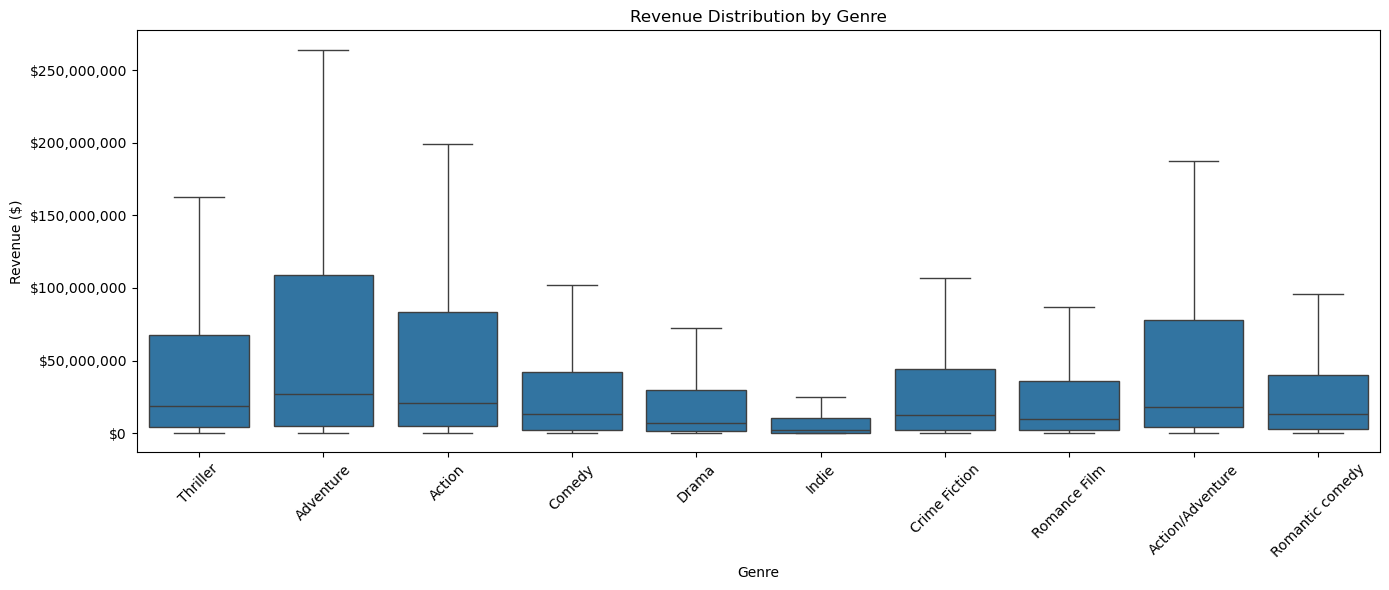

In [196]:
# plot box plots for each genre
plt.figure(figsize=(14, 6))
sns.boxplot(x='movie_genres', y='combined_revenue', data=df_genre_revenue, showfliers=False) # when True the outliers are shown (doesn't look good)
plt.xticks(rotation=45)
plt.title('Revenue Distribution by Genre')
plt.xlabel('Genre')
plt.ylabel('Revenue ($)')
plt.gca().yaxis.set_major_formatter(lambda x, p: f'${x:,.0f}')
plt.tight_layout()
plt.show()

<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
</div>


#### 3. How has the revenue of each genre changed over time?

This question aims to answer whether certain genres have more (or less) popular or profitable over time.

<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

  - Time series analysis
  - Visualization: Line plot
</div>

We will first plot a line plot showing the trend of average revenue for each genre across years. Given that we are analyzing 10 genres, we will use a facet gird for clarity. 

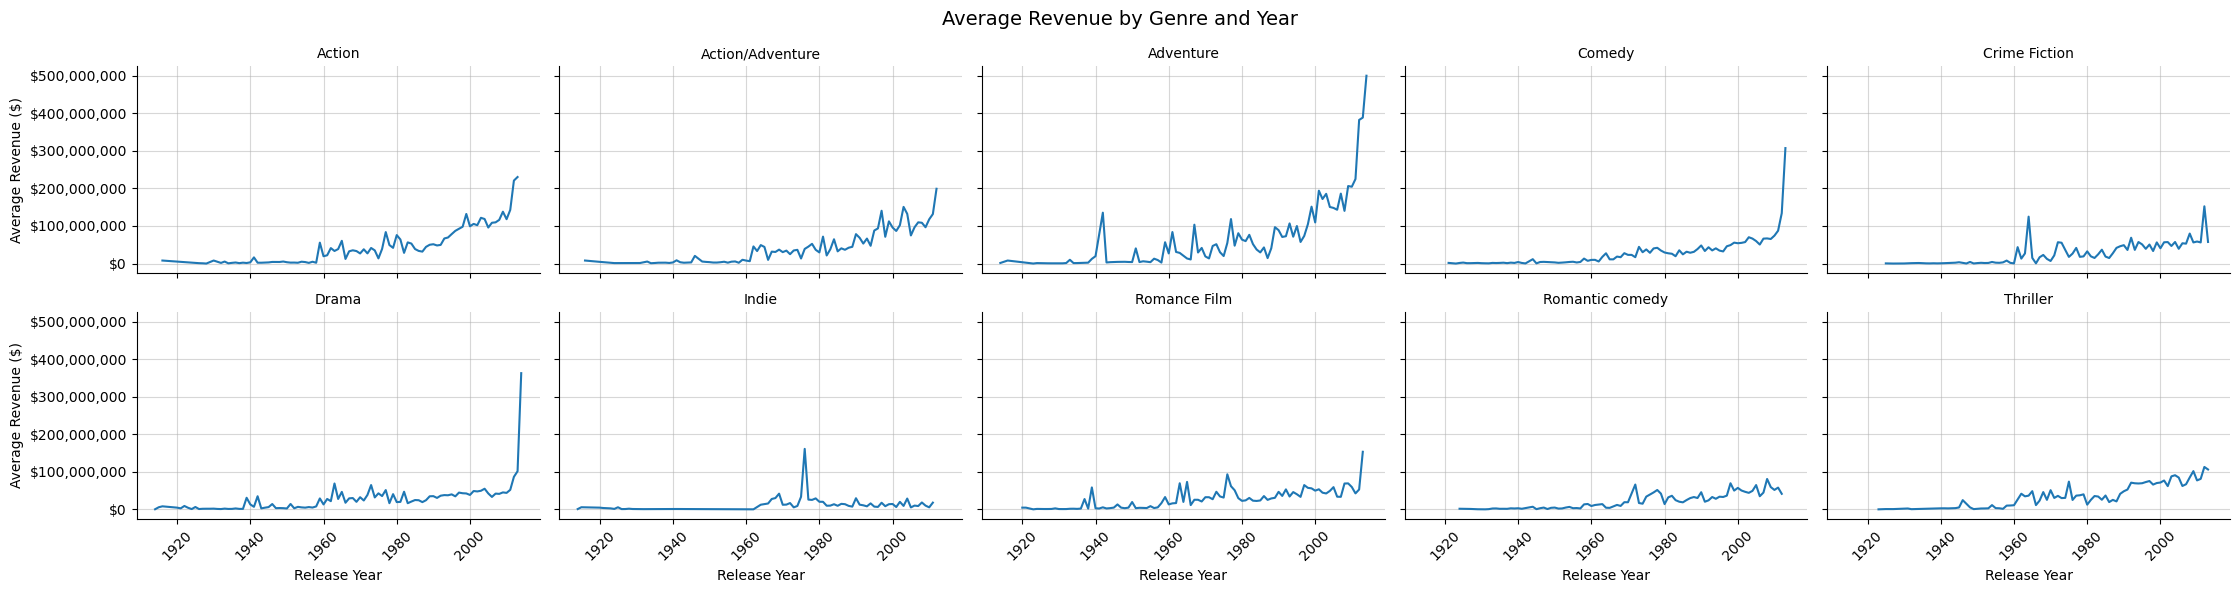

In [197]:
# calculate average revenue by genre and year
genre_year_revenue = df_genre_revenue.groupby(['movie_genres', 'release_year'])['combined_revenue'].mean().reset_index()
# create facet grid of line plots
g = sns.FacetGrid(genre_year_revenue, col='movie_genres', col_wrap=5, height=3, aspect=1.5)
g.map_dataframe(sns.lineplot, x='release_year', y='combined_revenue')
g.set_axis_labels('Release Year', 'Average Revenue ($)')
g.set_titles('{col_name}')
# format y-axis to use dollars
for ax in g.axes:
    ax.yaxis.set_major_formatter(lambda x, p: f'${x:,.0f}')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.5)
plt.suptitle('Average Revenue by Genre and Year', fontsize=14)
plt.tight_layout()
plt.show()


<div class="alert alert-info">
  💡 <strong>Discussion:</strong>
  
</div>


#### 5. Are there any trends in genre popularity over time, and how do they correlate with revenue changes?

This question aims to determine if changes in revenue for a genre correspond with changes in the number of movies produced in that genre.


<div class="alert alert-warning">

  🛠️ <strong>Methods:</strong>

</div>